In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import Angle, EarthLocation, AltAz, SkyCoord
import astropy.units as u
from astropy.constants import R_earth

import datetime

In [2]:
mjd_unixtimestamp_offset = 10587.5
seconds_in_day = 3600 * 24

def mjd2unixtimestamp(m):
    return (m - mjd_unixtimestamp_offset) * seconds_in_day

def azel(x):
    az = Angle(np.arctan2(x[:,1], -x[:,0]), unit = u.rad).wrap_at('360d')
    el = Angle(np.arctan2(x[:,2], np.sqrt(x[:,0]**2 + x[:,1]**2)), unit = u.rad)
    return az, el

def rangerate(x):
    return np.sum(x[:,:3] * x[:,3:], axis=1) / np.sqrt(np.sum(x[:,:3]**2, axis=1)) * u.km/u.s

In [3]:
PATH = 'set1/'
report = np.fromfile(PATH + 'Tianwen1_RADEC_RMAG.txt', sep = ' ').reshape((-1,4))
t = Time(mjd2unixtimestamp(report[:,0]), format='unix')
ra = Angle(report[:,1], unit = u.deg)
dec = Angle(report[:,2], unit = u.deg)
rmag = report[:,3] * u.km

PATH = 'set2_fwd/'
report2 = np.fromfile(PATH + 'Tianwen1_RADEC_RMAG.txt', sep = ' ').reshape((-1,4))
t2 = Time(mjd2unixtimestamp(report2[:,0]), format='unix')
ra2 = Angle(report2[:,1], unit = u.deg)
dec2 = Angle(report2[:,2], unit = u.deg)
rmag2 = report2[:,3] * u.km

PATH = 'set3_fwd/'
report3 = np.fromfile(PATH + 'Tianwen1_RADEC_RMAG.txt', sep = ' ').reshape((-1,4))
t3 = Time(mjd2unixtimestamp(report3[:,0]), format='unix')
ra3 = Angle(report3[:,1], unit = u.deg)
dec3 = Angle(report3[:,2], unit = u.deg)
rmag3 = report3[:,3] * u.km

PATH = 'set3/'
report3b = np.fromfile(PATH + 'Tianwen1_RADEC_RMAG.txt', sep = ' ').reshape((-1,4))
t3b = Time(mjd2unixtimestamp(report3b[:,0]), format='unix')
t3b_sel = t3b >= t[0]
t3b = t3b[t3b_sel]
ra3b = Angle(report3b[t3b_sel,1], unit = u.deg)
dec3b = Angle(report3b[t3b_sel,2], unit = u.deg)
rmag3b = report3b[t3b_sel,3] * u.km

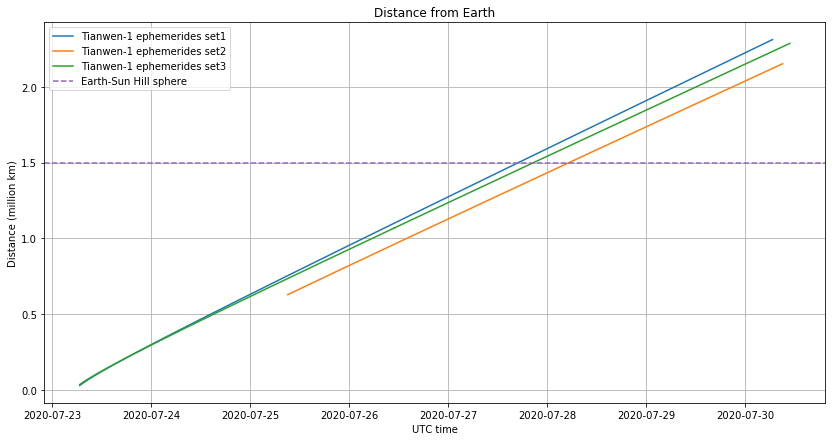

In [4]:
plt.figure(figsize = (14,7), facecolor = 'w')
plt.plot(t.datetime, rmag * 1e-6, label = 'Tianwen-1 ephemerides set1')
plt.plot(t2.datetime, rmag2 * 1e-6, label = 'Tianwen-1 ephemerides set2')
plt.plot(t3.datetime, rmag3 * 1e-6, color = 'C2', label = 'Tianwen-1 ephemerides set3')
plt.plot(t3b.datetime, rmag3b * 1e-6, color = 'C2')
plt.axhline(y = 1.5, linestyle = '--', color = 'C4', label = 'Earth-Sun Hill sphere')
plt.xlabel('UTC time')
plt.ylabel('Distance (million km)')
plt.title('Distance from Earth')
plt.grid()
plt.legend();

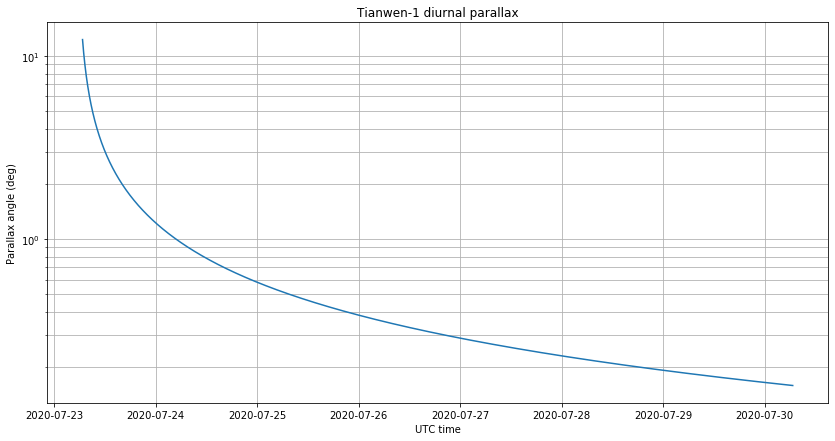

In [5]:
parallax = np.arctan(R_earth/rmag).to(u.deg)

plt.figure(figsize = (14,7), facecolor = 'w')
plt.semilogy(t.datetime, parallax)
plt.xlabel('UTC time')
plt.ylabel('Parallax angle (deg)')
plt.title('Tianwen-1 diurnal parallax')
plt.grid(which = 'both');

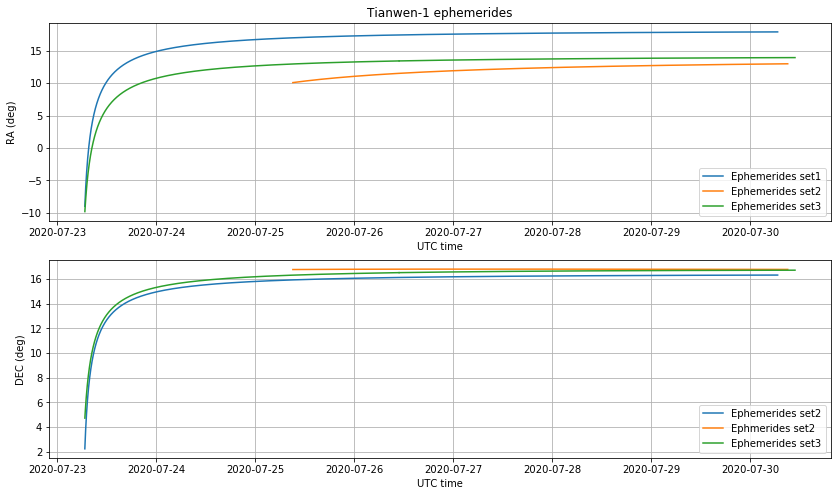

In [6]:
fig, ax = plt.subplots(2,1, figsize = (14,8), facecolor = 'w')
ax[0].plot(t.datetime, ra, label = 'Ephemerides set1')
ax[0].plot(t2.datetime, ra2, label = 'Ephemerides set2') 
ax[0].plot(t3.datetime, ra3, label = 'Ephemerides set3')
ax[0].plot(t3b.datetime, ra3b, color = 'C2')
ax[1].plot(t.datetime, dec, label = 'Ephemerides set2')
ax[1].plot(t2.datetime, dec2, label = 'Ephmerides set2')
ax[1].plot(t3.datetime, dec3, label = 'Ephemerides set3')
ax[1].plot(t3b.datetime, dec3b, color = 'C2')
for a in ax:
    a.grid()
    a.set_xlabel('UTC time')
    a.legend()
ax[0].set_ylabel('RA (deg)')
ax[1].set_ylabel('DEC (deg)')
ax[0].set_title(f'Tianwen-1 ephemerides');

In [7]:
sets = ['set1', 'set2', 'set2_fwd', 'set3']

def plot_pointings(data_name, pointings_altaz, observer, start, end, observer_name):
    pointings = SkyCoord(pointings_altaz).transform_to('icrs') 
    sel_p = (pointings.obstime >= Time(start)) & (pointings.obstime <= Time(end))
    
    fig, ax = plt.subplots(2,1, figsize = (14,8), facecolor = 'w')
    
    for s in sets:
        data = np.fromfile(s + '/' + data_name, sep = ' ').reshape((-1,7))
        t = Time(mjd2unixtimestamp(data[:,0]), format='unix')
        azels = azel(data[:,1:])
        altaz = AltAz(az = azels[0], alt = azels[1], obstime = t, location = observer)
        radec = SkyCoord(altaz).transform_to('icrs')
        sel = (t >= Time(start)) & (t <= Time(end))
        ax[0].plot(t[sel].datetime, radec[sel].ra.wrap_at('180d'), label = f'Tianwen-1 ephemerides {s}')
        ax[1].plot(t[sel].datetime, radec[sel].dec, label = f'Tianwen-1 ephemerides {s}')

    ax[0].plot(pointings[sel_p].obstime.datetime,
           pointings[sel_p].ra.wrap_at('180d'), 'o', label = 'Antenna pointing')   
    ax[1].plot(pointings[sel_p].obstime.datetime,
           pointings[sel_p].dec, 'o', label = 'Antenna pointing')
    ax[0].grid()
    ax[1].grid()
    for a in ax:
        a.set_xlabel('UTC time')
        a.legend()
        a.set_xlim((Time(start).datetime, Time(end).datetime))
    ax[0].set_ylabel('RA (deg)')
    ax[1].set_ylabel('DEC (deg)')
    ax[0].set_title(f'Antenna pointings from {observer_name}')
    
def pointing_to_altaz(pointing, location):
    t = Time([l.split('\t')[0] for l in pointing.split('\n')])
    az = Angle([l.split('\t')[1]+'d' for l in pointing.split('\n')])
    alt = Angle([l.split('\t')[2]+'d' for l in pointing.split('\n')])
    return AltAz(az = az, alt = alt, obstime = t, location = location)

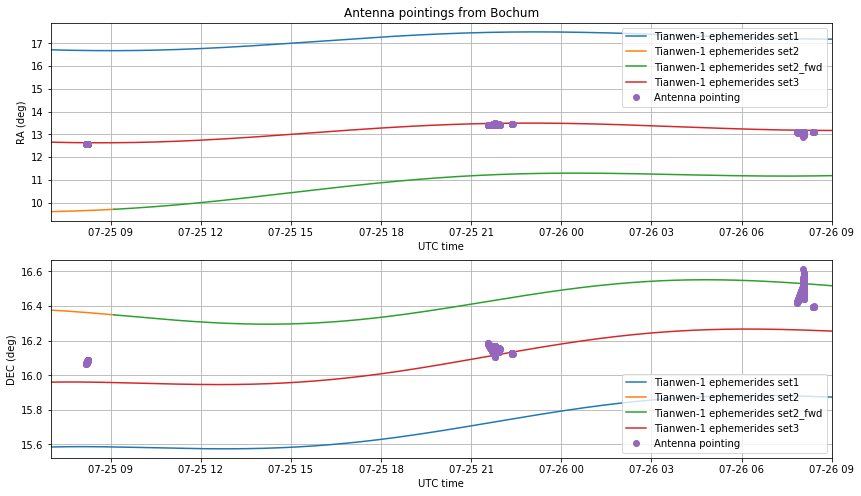

In [8]:
bochum = EarthLocation(lat=51.426990*u.deg, lon=7.192566*u.deg, height=156.65*u.m)

with open('putty_Bochum.log') as f:
    azels_bochum = ['2020-07-25T' + l for l in f if l.startswith('081')]
with open('putty200725_2135Z.log') as f:
    azels_bochum.extend(['2020-07-25T' + l for l in f if l.startswith('21')])
with open('putty200725_2221Z.log') as f:
    azels_bochum.extend(['2020-07-25T' + l for l in f if l.startswith('22')])
with open('putty20200726_095035.log') as f:
    azels_bochum.extend(['2020-07-26T' + l for l in f if '|' in l and 'TIANWEN-1' in l])
with open('putty20200726_102302.log') as f:
    azels_bochum.extend(['2020-07-26T' + l for l in f if '|' in l and 'TIANWEN-1' in l])
    
azels_bochum_t = [datetime.datetime.strptime(a.split()[0].replace('.',':'), '%Y-%m-%dT%H%M:%S')
                  for a in azels_bochum]
bochum_az_correction = -0.299 * u.deg # as per X-band feed slightly offset
azels_bochum_az = np.array([float(a.split()[1]) for a in azels_bochum]) * u.deg + bochum_az_correction
azels_bochum_el = np.array([float(a.split()[2]) for a in azels_bochum]) * u.deg

bochum_antenna_altaz = AltAz(az = azels_bochum_az, alt = azels_bochum_el,
                             obstime = azels_bochum_t, location = bochum)

plot_pointings('Tianwen1_Bochum.txt', bochum_antenna_altaz, bochum,
              '2020-07-25T07:00', '2020-07-26T09:00', 'Bochum')

In [9]:
start = '2020-07-23T06:00'
end = '2020-07-26T09:00'

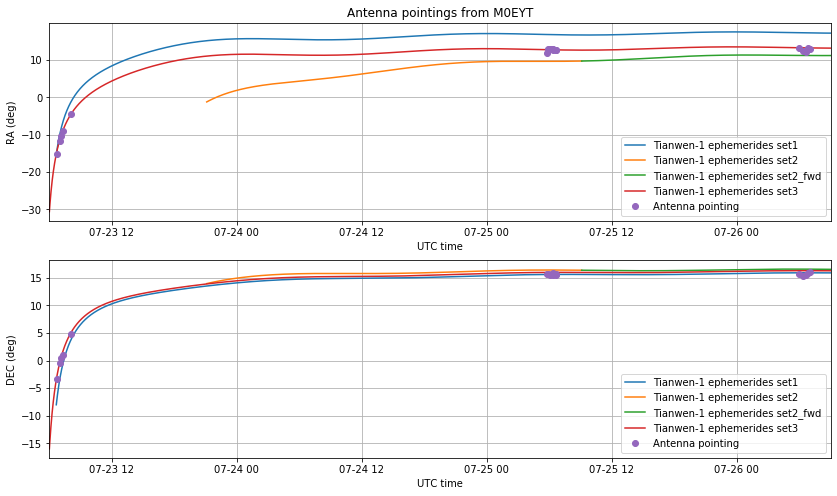

In [10]:
# location precision reduced for privacy
m0eyt = EarthLocation(lat = 50.8*u.deg, lon = 358.0*u.deg, height = 0*u.m)

m0eyt_pointing = """2020-07-23 06:42:00	239.44	18.73
2020-07-23 07:03:00	242.70	20.10
2020-07-23 07:08:00	243.17	20.93
2020-07-23 07:16:00	244.10	20.89
2020-07-23 08:06:00	253.50	19.35
2020-07-25 05:45:00	205.30	52.80
2020-07-25 05:55:00	207.56	52.48
2020-07-25 06:03:00	210.25	51.65
2020-07-25 06:13:00	214.07	50.95
2020-07-25 06:19:00	216.22	50.68
2020-07-25 06:23:00	217.89	49.85
2020-07-25 06:36:00	222.07	48.53
2020-07-25 06:40:00	223.39	48.18
2020-07-26 06:00:00	210.29	51.92
2020-07-26 06:21:00	218.45	49.32
2020-07-26 06:39:00	224.86	47.52
2020-07-26 06:51:00	227.74	46.81
2020-07-26 07:00:00	230.78	45.89"""

plot_pointings('Tianwen1_M0EYT.txt', pointing_to_altaz(m0eyt_pointing, m0eyt), m0eyt,
              start, end, 'M0EYT')

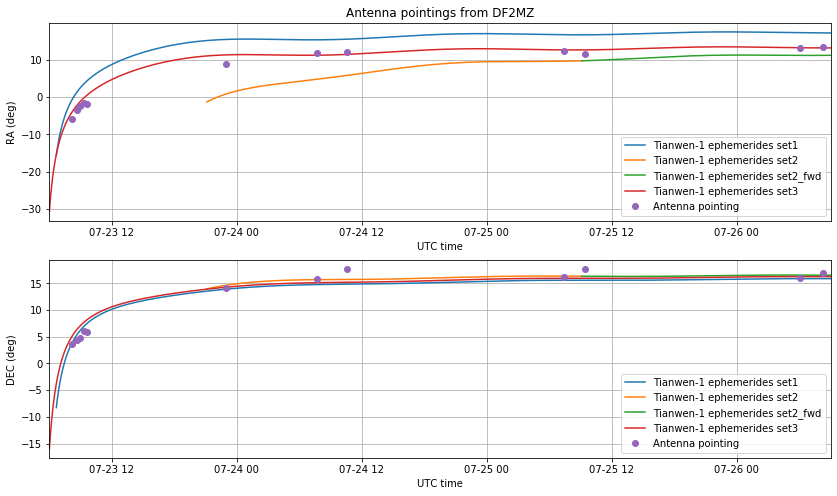

In [11]:
df2mz = EarthLocation(lat = 54.353222*u.deg, lon=10.279056*u.deg, height = 0.034*u.m)

df2mz_pointing = """2020-07-23 08:10:00	264.00	9.00
2020-07-23 08:37:00	268.00	7.00
2020-07-23 08:57:00	271.50	5.00
2020-07-23 09:21:00	276.50	3.00
2020-07-23 09:36:00	279.50	0.50
2020-07-23 22:56:00	95.50	21.50
2020-07-24 07:44:00	251.50	32.00
2020-07-24 10:36:00	288.00	9.00
2020-07-25 07:26:00	248.00	34.50
2020-07-25 09:26:00	275.50	18.00
2020-07-26 06:03:00	225.50	44.50
2020-07-26 08:17:00	260.00	28.00"""

plot_pointings('Tianwen1_DF2MZ.txt', pointing_to_altaz(df2mz_pointing, df2mz), df2mz,
              start, end, 'DF2MZ')

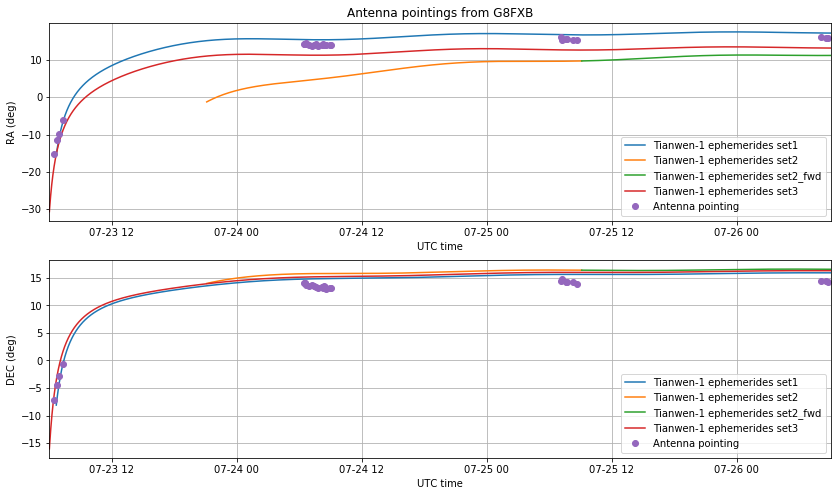

In [12]:
g8fxb = EarthLocation(lat = 51.660140*u.deg, lon = 0.447860*u.deg, height = 97*u.m)

g8fxb_pointing = """2020-07-23 06:29:00	236.50	15.40
2020-07-23 06:44:00	238.00	17.60
2020-07-23 06:54:00	239.70	18.60
2020-07-23 07:17:00	242.70	19.40
2020-07-24 06:28:00	217.80	47.30
2020-07-24 06:32:00	219.00	47.00
2020-07-24 06:35:00	220.00	46.70
2020-07-24 06:41:00	221.40	45.90
2020-07-24 06:55:00	226.30	44.00
2020-07-24 07:14:00	232.30	41.60
2020-07-24 07:24:00	234.60	40.50
2020-07-24 07:38:00	238.00	38.50
2020-07-24 07:47:00	240.60	37.00
2020-07-24 08:08:00	245.60	34.40
2020-07-24 08:14:00	246.80	33.60
2020-07-24 08:23:00	249.50	32.30
2020-07-24 08:28:00	250.40	31.50
2020-07-24 08:36:00	252.10	30.00
2020-07-24 08:55:00	256.20	27.30
2020-07-24 09:01:00	257.40	26.40
2020-07-25 07:07:00	228.90	43.90
2020-07-25 07:12:00	231.60	43.30
2020-07-25 07:34:00	237.20	40.00
2020-07-25 07:42:00	239.40	39.00
2020-07-25 08:18:00	248.40	33.80
2020-07-25 08:37:00	252.50	30.90
2020-07-26 08:05:00	245.70	35.70
2020-07-26 08:34:00	252.60	31.30
2020-07-26 08:48:00	255.60	29.20"""

plot_pointings('Tianwen1_G8FXB.txt', pointing_to_altaz(g8fxb_pointing, g8fxb), g8fxb,
              start, end, 'G8FXB')

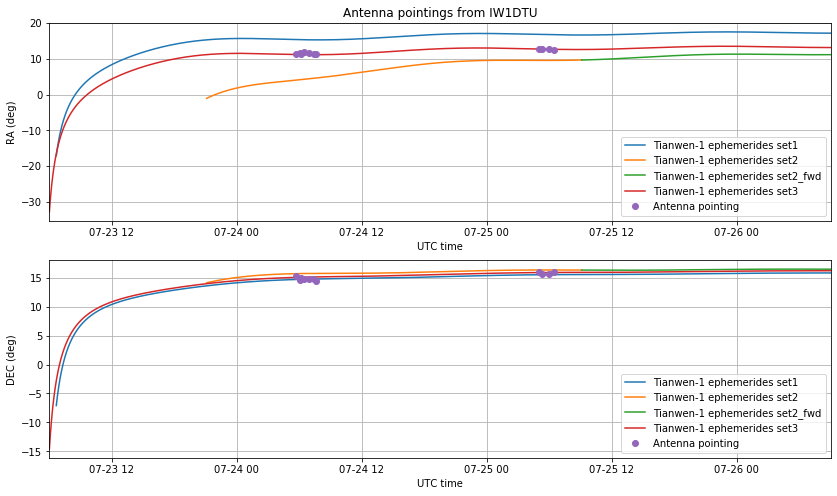

In [13]:
# location precision reduced for privacy
iw1dtu = EarthLocation(lat = 45.3*u.deg, lon = 7.7*u.deg, height = 0*u.m)

iw1dtu_pointing = """2020-07-24 05:42:00	222.00	54.00
2020-07-24 06:03:00	228.00	51.00
2020-07-24 06:10:00	231.00	50.00
2020-07-24 06:26:00	235.00	48.00
2020-07-24 06:58:00	244.00	43.00
2020-07-24 07:27:00	251.00	38.00
2020-07-24 07:38:00	253.00	36.00
2020-07-25 04:58:00	204.00	59.00
2020-07-25 05:18:00	212.50	57.00
2020-07-25 05:58:00	227.00	52.50
2020-07-25 06:28:00	237.00	48.50"""

plot_pointings('Tianwen1_IW1DTU.txt', pointing_to_altaz(iw1dtu_pointing, iw1dtu), iw1dtu,
              start, end, 'IW1DTU')